In [18]:
# from collections import Counter
# from functools import partial

import numpy as np
rng = np.random.default_rng()
np.set_printoptions(suppress=True, linewidth=180, edgeitems=5)
from tqdm.notebook import tqdm, trange
from tqdm.contrib.concurrent import process_map

from scipy.stats import rankdata
import seaborn as sns
sns.color_palette("tab10")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import pandas as pd
import warnings

# Setup

In [5]:
def train_model(i, student):
    verbose = False
    if student == 1:
        print(f'student == {student:.3f}')
        verbose = True
    model = make_model()
    Xtrain, Ytrain = make_data(student, 2**16, disable=not verbose)
    model.fit(Xtrain, Ytrain, verbose=verbose)
    reward = eval_model(model, 10000, disable=not verbose)
    model.save(f'models/2x{ms}/starting_{student:.3f}_{i}.keras')
    # model.save_weights(f'models/starting_{student:.3f}_{i}.weights.h5')
    return reward

In [ ]:
%%time

iters = list(range(10))
iter_students = [100 for i in iters]
rewards = process_map(train_model, iters, iter_students, disable=False, max_workers=20)

# rewards = process_map(train_model, students, disable=True, max_workers=17)

In [ ]:
for r, s in zip(rewards, students):
    
    res = r[0]*r[1]
    res = res.sum(axis=1).mean()
    
    print(f"{s:.3f} {res}")

In [4]:
%%time
ntotal = (2**np.array(ns[1:13])).sum()

currs = process_map(make_data, students, [ntotal]*len(students), max_workers=17, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 111 ms, sys: 244 ms, total: 354 ms
Wall time: 9.84 s


# Eval Training

In [2]:
from config import ms, students

In [3]:
from helpers import *

In [4]:
%%time

ntotal = (2**np.array(ns[1:13])).sum()
currs = process_map(make_data, students, [ntotal]*len(students), max_workers=17, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))


  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 116 ms, sys: 230 ms, total: 345 ms
Wall time: 12 s


In [17]:
_X, _Y = currs[f"{0.1:.3f}"]
_X, _Y = _X[:32], _Y[:32]

In [47]:
def eval_training(modeli, student, teachers, save=False, pct=0):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.get_logger().setLevel('ERROR')
    
    def get_r(model):
        r0, r1 = eval_model(model, 10)
        r = (r0*r1).sum(axis=1).mean()
        return r
        
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(CustomCallback, self).__init__()
        def on_batch_begin(self, batch, logs=None):            
            if save and batch % 1 == 0:
                self.model.rewards[batch] = get_r(self.model)
    
    if student == -1:
        model2 = make_model()
    else:
        model2 = tf.keras.models.load_model(f"models/2x{ms}/starting_{student:.3f}_{modeli%10}.keras")
        
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    model2.rewards = {}
    
    bs = 32
    
    rng = np.random.default_rng(modeli)
    
    X, Y = [], []
    for teacher, n in teachers:
        if isinstance(teacher, tuple):
            X.append([])
            Y.append([])
            for teacher_part in teacher:
                _X, _Y = currs[f"{teacher_part:.3f}"]
                perm = np.random.default_rng(modeli).permutation(len(_X))[:bs * n//len(teacher)]
                # perm = np.random.permutation(len(_X))[:bs * n//len(teacher)]
                X[-1].append(_X[perm])
                Y[-1].append(_Y[perm])
            X[-1] = np.concatenate(X[-1])
            Y[-1] = np.concatenate(Y[-1])
            perm = np.random.permutation(len(X[-1]))
            X[-1] = X[-1][perm]
            Y[-1] = Y[-1][perm]
        else:
            _X, _Y = currs[f"{teacher:.3f}"]
            perm = np.random.permutation(len(_X))[:n*bs]
            X.append(_X[perm])
            Y.append(_Y[perm])

    lx = len(X[0])
    if pct:
        assert (pct*lx) % 1 == 0
        pct2 = int(pct * lx)
        mixX = np.concatenate([_X[lx-pct2:] for _X in X])
        mixY = np.concatenate([_Y[lx-pct2:] for _Y in Y])
        for i, (_X, _Y) in enumerate(zip(X, Y)):
            _X[lx-pct2:] = mixX[i::len(X)]
            _Y[lx-pct2:] = mixY[i::len(Y)]
            perm = np.random.permutation(lx)
            _X[:] = _X[perm]
            _Y[:] = _Y[perm]
    
    X, Y = np.concatenate(X), np.concatenate(Y)        
    model2.fit(X, Y, verbose=False, shuffle=False, batch_size=bs, callbacks=[CustomCallback()]) 
    model2.rewards[len(X)//bs] = get_r(model2)
        
    # with open('/storage1/fs1/chien-ju.ho/Active/gym/tree3.txt', 'a') as f:
    #     for k, v in model2.rewards.items():
    #         print(f"{student};{teachers};{pct};{modeli};{k};{v}", file=f, flush=True)

    return (modeli, student, teachers, model2.rewards)


In [70]:
%%time
res1 = [eval_training(0, 100, [((0.1,0.01), 30)], save=True, pct=0) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 57s, sys: 5.96 s, total: 2min 3s
Wall time: 1min 55s


In [71]:
%%time
res3 = [eval_training(0, 100, [(0.1, 15), (0.01, 15)], save=True, pct=0) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 58s, sys: 5.72 s, total: 2min 3s
Wall time: 1min 55s


In [72]:
res1_ = np.array([list(i[3].values()) for i in res1]).mean(axis=0)
# res2_ = np.array([list(i[3].values()) for i in res2]).mean(axis=0)
res3_ = np.array([list(i[3].values()) for i in res3]).mean(axis=0)
res1_.shape, res3_.shape

((31,), (31,))

In [73]:
res1_[-1], res3_[-2]

(0.7355278940291496, 0.7333047609497784)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<Axes: >

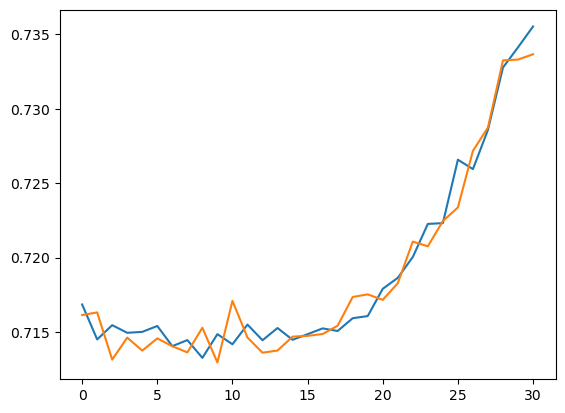

In [74]:
sns.lineplot(res1_)
# sns.lineplot(res2_)
sns.lineplot(res3_)

In [ ]:
def exp2(mode, n, nb=100):
    modeli = list(range(n))
    students = [-1, 100]
    saves = [False]
    pcts = [0]
    
    if mode == 'one':
        teachers = [[(t, nb*2)] for t in [0.01, 0.032, 0.1, 0.316, 1., 3.162, 10.]]
        saves = [True]
    
    elif mode == 'two-A':
        teachers = (
            [[((0.01,0.1,1.,10.), i)] for i in range(4, nb+1, 4)]
            + [[((10.,1.), i//2), ((0.1,0.01), i//2)] for i in range(4, nb+1, 4)]
            + [[(10., i//4), (1., i//4), (0.1, i//4), (0.01, i//4)] for i in range(4, nb+1, 4)]
        )
        
    
    elif mode == 'two-B':
        teachers = [[((10.,1.), i//2), ((0.1,0.01), i//2)] for i in range(10, nb+1, 10)]
        pcts = [0, 0.2, 0.4, 0.6, 0.8, 1]
        
    elif mode.startswith('split'):
        k = int(mode[-1])
        teachers = [[(0.1, i*k), (0.01, i)] for i in range(5, nb//2+1, 5)]
        
    elif mode.startswith('optimal'):
        k = int(mode[-1])
        teachers = []
        for budget in range(10, nb+1, 10):
            for split in range(0, budget+1, 5):
                teachers.append([(0.1, k*split), (0.01, (budget-split))])
        
    # elif mode.startswith('algo'):
    #     k = int(mode[-1])
    #     teachers = [[(0.1, i*k), (0.01, i)] for i in range(1, nb//2+1)]

        
    
    combo = list(product(modeli, students, teachers, saves, pcts))
    # print(combo[::10])
    # print(teachers)
    return process_map(eval_training, *zip(*combo), chunksize=1, ncols=80)

In [19]:
%%time
model2.fit(_X, _Y, batch_size=bs, verbose=0, callbacks=[CustomCallback(), TqdmCallback(verbose=1, ncols=80)], epochs=100) 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

CPU times: user 11.4 s, sys: 8.69 s, total: 20.1 s
Wall time: 33.8 s


# Results New

In [12]:
import seaborn as sns
sns.color_palette("tab10")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import pandas as pd
import warnings

In [5]:
df = pd.read_csv('/storage1/fs1/chien-ju.ho/Active/gym/tree/tree4.txt',
                 names=['Student','Teacher','Pct','Exp','Batch','Perf'],
                 sep = ';')
df = df[df.Student==-1]

In [6]:
df

,Student,Teacher,Pct,Exp,Batch,Perf
0,-1,"[(10.0, 200)]",0.0,0,0,0.687707
1,-1,"[(10.0, 200)]",0.0,0,1,0.709306
2,-1,"[(10.0, 200)]",0.0,0,2,0.710824
3,-1,"[(10.0, 200)]",0.0,0,3,0.705246
4,-1,"[(10.0, 200)]",0.0,0,4,0.721493
...,...,...,...,...,...,...
3678385,-1,"[(0.1, 291), (0.01, 3)]",0.0,49,294,0.970075
3678386,-1,"[(0.1, 294), (0.01, 2)]",0.0,49,296,0.966958
3678387,-1,"[(0.1, 288), (0.01, 4)]",0.0,49,292,0.970305
3678391,-1,"[(0.1, 300), (0.01, 0)]",0.0,49,300,0.966468


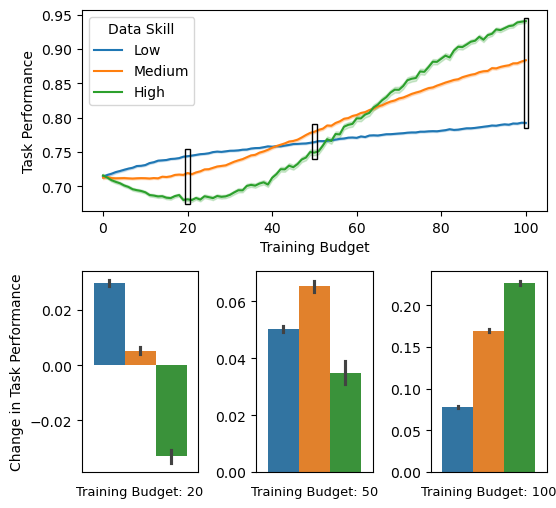

In [13]:
subs = {}
subs['one'] = [str([(i, 200)]) for i in [
    0.010,
    0.100,
    1.000,
]]

df2 = df[df.Teacher.isin(subs['one'])].copy()
df2['Teacher'] = df2.Teacher.apply(lambda x: str(eval(x)[0][0]))
df2 = df2.sort_values('Teacher', key=lambda x: x.astype(float))
df2['Teacher'] = df2['Teacher'].replace(dict(zip(df2['Teacher'].unique(), ['High', 'Medium', 'Low'])))
df2 = df2.rename(columns={'Teacher':'Data Skill', 'Batch':'Budget'})
df2['PerfChange'] = df2.Perf - df2[df2.Budget==0].Perf.mean()

df2['sortkey'] = df2['Data Skill'].apply(lambda x: ['Low', 'Medium', 'High'].index(x))
df2 = df2.sort_values('sortkey')


fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(wspace = 0.5, hspace=0.3)

gs = fig.add_gridspec(2,3)
ax0 = fig.add_subplot(gs[0, :])
ax1 = [fig.add_subplot(gs[1, i]) for i in range(3)]


with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[df2.Budget<=100], x='Budget', y='Perf', hue='Data Skill', errorbar='se', ax=ax0)
    ax.set(
        xlabel='Training Budget',
        ylabel='Task Performance'
    )
    
    
    
for i, budget in enumerate([20, 50, 100]):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.barplot(df2[df2.Budget==budget], x='Budget', y='PerfChange', hue='Data Skill', errorbar='se', ax=ax1[i])
        ax.tick_params(labelbottom = False, bottom = False) 
        ax.set_xlabel(f'Training Budget: {budget}', labelpad=10, fontsize=9.3)
        ax.set_ylabel('' if i else 'Change in Task Performance')
        ax.get_legend().set_visible(False)
        
rect = patches.Rectangle((19.5,0.674), 1, 0.08, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)

rect = patches.Rectangle((49.5,0.74), 1, 0.05, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)

rect = patches.Rectangle((99.5,0.785), 1, 0.16, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)


# fig.savefig('images/tree-1.2.pdf', bbox_inches='tight')
plt.show()

# Results

In [28]:
df = pd.read_csv('/storage1/fs1/chien-ju.ho/Active/gym/tree/tree4.txt',
                 names=['Student','Teacher','Pct','Exp','Batch','Perf'],
                 sep = ';')
df = df[df.Student==100]

In [29]:
df

,Student,Teacher,Pct,Exp,Batch,Perf
402,100,"[(10.0, 200)]",0.0,0,0,0.716509
403,100,"[(10.0, 200)]",0.0,0,1,0.715341
404,100,"[(10.0, 200)]",0.0,0,2,0.715651
405,100,"[(10.0, 200)]",0.0,0,3,0.717208
406,100,"[(10.0, 200)]",0.0,0,4,0.714916
...,...,...,...,...,...,...
3714163,100,algo-3,0.0,495,95,0.998761
3714164,100,algo-3,0.0,496,95,0.996851
3714165,100,algo-3,0.0,497,95,0.999749
3714166,100,algo-3,0.0,498,95,0.999327


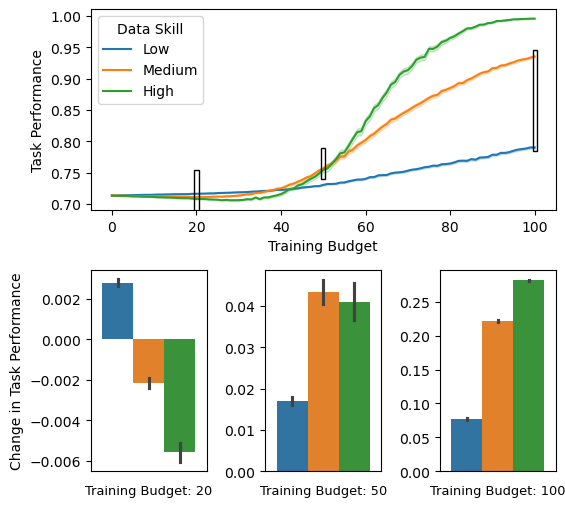

In [30]:
subs = {}
subs['one'] = [str([(i, 200)]) for i in [
    0.010,
    0.100,
    1.000,
]]

df2 = df[df.Teacher.isin(subs['one'])].copy()
df2['Teacher'] = df2.Teacher.apply(lambda x: str(eval(x)[0][0]))
df2 = df2.sort_values('Teacher', key=lambda x: x.astype(float))
df2['Teacher'] = df2['Teacher'].replace(dict(zip(df2['Teacher'].unique(), ['High', 'Medium', 'Low'])))
df2 = df2.rename(columns={'Teacher':'Data Skill', 'Batch':'Budget'})
df2['PerfChange'] = df2.Perf - df2[df2.Budget==0].Perf.mean()

df2['sortkey'] = df2['Data Skill'].apply(lambda x: ['Low', 'Medium', 'High'].index(x))
df2 = df2.sort_values('sortkey')


fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(wspace = 0.5, hspace=0.3)

gs = fig.add_gridspec(2,3)
ax0 = fig.add_subplot(gs[0, :])
ax1 = [fig.add_subplot(gs[1, i]) for i in range(3)]


with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[df2.Budget<=100], x='Budget', y='Perf', hue='Data Skill', errorbar='se', ax=ax0)
    ax.set(
        xlabel='Training Budget',
        ylabel='Task Performance'
    )
    
    
    
for i, budget in enumerate([20, 50, 100]):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.barplot(df2[df2.Budget==budget], x='Budget', y='PerfChange', hue='Data Skill', errorbar='se', ax=ax1[i])
        ax.tick_params(labelbottom = False, bottom = False) 
        ax.set_xlabel(f'Training Budget: {budget}', labelpad=10, fontsize=9.3)
        ax.set_ylabel('' if i else 'Change in Task Performance')
        ax.get_legend().set_visible(False)
        
rect = patches.Rectangle((19.5,0.674), 1, 0.08, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)

rect = patches.Rectangle((49.5,0.74), 1, 0.05, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)

rect = patches.Rectangle((99.5,0.785), 1, 0.16, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)


# fig.savefig('images/tree-1.2.pdf', bbox_inches='tight')
plt.show()

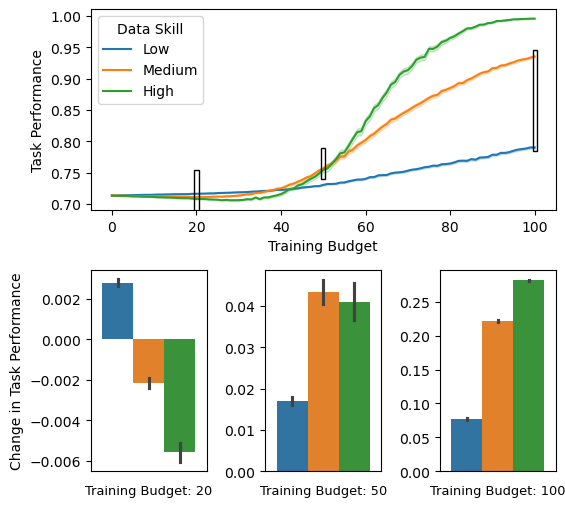

In [32]:
subs = {}
subs['one'] = [str([(i, 200)]) for i in [
    0.010,
    0.100,
    1.000,
]]

df2 = df[df.Teacher.isin(subs['one'])].copy()
df2['Teacher'] = df2.Teacher.apply(lambda x: str(eval(x)[0][0]))
df2 = df2.sort_values('Teacher', key=lambda x: x.astype(float))
df2['Teacher'] = df2['Teacher'].replace(dict(zip(df2['Teacher'].unique(), ['High', 'Medium', 'Low'])))
df2 = df2.rename(columns={'Teacher':'Data Skill', 'Batch':'Budget'})
df2['PerfChange'] = df2.Perf - df2[df2.Budget==0].Perf.mean()

df2['sortkey'] = df2['Data Skill'].apply(lambda x: ['Low', 'Medium', 'High'].index(x))
df2 = df2.sort_values('sortkey')


fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(wspace = 0.5, hspace=0.3)

gs = fig.add_gridspec(2,3)
ax0 = fig.add_subplot(gs[0, :])
ax1 = [fig.add_subplot(gs[1, i]) for i in range(3)]


with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[df2.Budget<=100], x='Budget', y='Perf', hue='Data Skill', errorbar='se', ax=ax0)
    ax.set(
        xlabel='Training Budget',
        ylabel='Task Performance'
    )
    
    
    
for i, budget in enumerate([20, 50, 100]):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.barplot(df2[df2.Budget==budget], x='Budget', y='PerfChange', hue='Data Skill', errorbar='se', ax=ax1[i])
        ax.tick_params(labelbottom = False, bottom = False) 
        ax.set_xlabel(f'Training Budget: {budget}', labelpad=10, fontsize=9.3)
        ax.set_ylabel('' if i else 'Change in Task Performance')
        ax.get_legend().set_visible(False)
        
rect = patches.Rectangle((19.5,0.674), 1, 0.08, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)

rect = patches.Rectangle((49.5,0.74), 1, 0.05, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)

rect = patches.Rectangle((99.5,0.785), 1, 0.16, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
ax0.add_patch(rect)


# fig.savefig('images/tree-1.2.pdf', bbox_inches='tight')
plt.show()

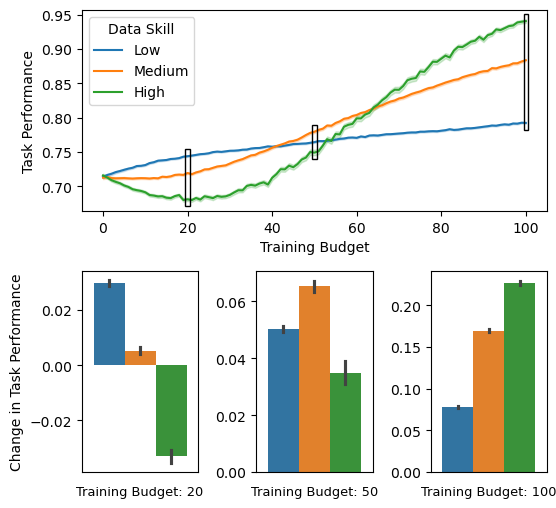

In [50]:
df = pd.read_csv('/storage1/fs1/chien-ju.ho/Active/gym/tree/tree4.txt',
                 names=['Student','Teacher','Pct','Exp','Batch','Perf'],
                 sep = ';')
df = df[df.Student==-1]

subs = {}
subs['one'] = [str([(i, 200)]) for i in [
    0.010,
    0.100,
    1.000,
]]

df2 = df[df.Teacher.isin(subs['one'])].copy()
df2['Teacher'] = df2.Teacher.apply(lambda x: str(eval(x)[0][0]))
df2 = df2.sort_values('Teacher', key=lambda x: x.astype(float))
df2['Teacher'] = df2['Teacher'].replace(dict(zip(df2['Teacher'].unique(), ['High', 'Medium', 'Low'])))
df2 = df2.rename(columns={'Teacher':'Data Skill', 'Batch':'Budget'})
df2['PerfChange'] = df2.Perf - df2[df2.Budget==0].Perf.mean()

df2['sortkey'] = df2['Data Skill'].apply(lambda x: ['Low', 'Medium', 'High'].index(x))
df2 = df2.sort_values('sortkey')


fig = plt.figure(figsize=(6,6))
plt.subplots_adjust(wspace = 0.5, hspace=0.3)

gs = fig.add_gridspec(2,3)
ax0 = fig.add_subplot(gs[0, :])
ax1 = [fig.add_subplot(gs[1, i]) for i in range(3)]

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2[df2.Budget<=100], x='Budget', y='Perf', hue='Data Skill', errorbar='se', ax=ax0)
    ax.set(
        xlabel='Training Budget',
        ylabel='Task Performance'
    )

for i, budget in enumerate([20, 50, 100]):
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.barplot(df2[df2.Budget==budget], x='Budget', y='PerfChange', hue='Data Skill', errorbar='se', ax=ax1[i])
        ax.tick_params(labelbottom = False, bottom = False) 
        ax.set_xlabel(f'Training Budget: {budget}', labelpad=10, fontsize=9.3)
        ax.set_ylabel('' if i else 'Change in Task Performance')
        ax.get_legend().set_visible(False)

for box in [20, 50, 100]:
    col = df2[df2.Budget==box].groupby('Data Skill').Perf.mean()
    rect = patches.Rectangle((box-0.5,col.min()-0.01), 1, col.max()-col.min()+0.02, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
    ax0.add_patch(rect)



# fig.savefig('images/tree-1.1.pdf', bbox_inches='tight')
plt.show()

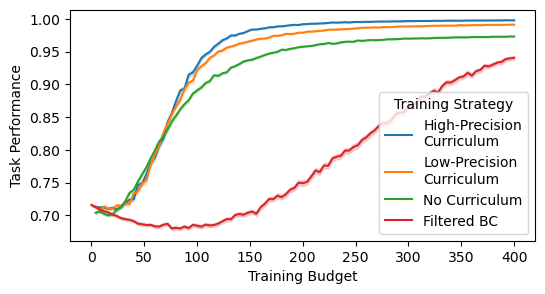

In [51]:
# High precision and low precision curriculua

subs['twoA'] = []
for nb in range(4,401,4):
    subs['twoA'].append(str([((0.01,0.032,0.1,0.316), nb)]))
    subs['twoA'].append(str([((0.316,0.1), nb//2), ((0.032,0.010), nb//2)]))
    subs['twoA'].append(str([(0.316, nb//4), (0.1, nb//4), (0.032, nb//4), (0.010, nb//4)]))

df2 = df[df.Teacher.isin(subs['twoA'])].copy()

df2 = df2[df2.Pct == 0]
df2['Teacher'] = df2.Teacher.apply(lambda x: f"{len(eval(x))} Stage")
df2 = df2.sort_values('Teacher')
                        
                        
filteredBC = df[df.Teacher==str([(0.01, 200)])].query('Batch <= 100')
filteredBC['Batch'] *= 4
filteredBC['Teacher'] = 'Filtered BC'
df2 = pd.concat([df2, filteredBC])
                        

df2 = df2.rename(columns={'Teacher':'Training Strategy'})
df2['Training Strategy'] = df2['Training Strategy'].replace({'4 Stage': 'High-Precision\nCurriculum',
                                        '2 Stage': 'Low-Precision\nCurriculum',
                                        '1 Stage': 'No Curriculum'})
df2 = df2.sort_values('Training Strategy', key=lambda x: -x.str.len())

fig, ax = plt.subplots(figsize=(6,3))
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Training Strategy', errorbar='se')
    ax.set(
        xlabel='Training Budget',
        ylabel='Task Performance'
    )

# df2['PerfChange'] = df2.Perf - df2[df2.Batch==0].Perf.mean()
# df2 = df2.sort_values('Strategy', key=lambda x: -x.str.len())

# fig, ax = plt.subplots(figsize=(10,5))
# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)
#     ax = sns.barplot(df2[df2.Batch==100], x='Strategy', y='PerfChange', errorbar='se', dodge=False)

#     ax.set(
#         xlabel='',
#         ylabel='Change in Task Performance'
#     )


# plt.savefig('images/tree-2.1.pdf', bbox_inches='tight')
plt.show()

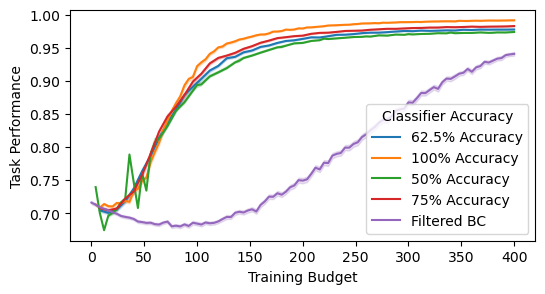

In [52]:
# Classifier Accuracy Curricula

subs['twoB'] = []
for nb in range(4,401,4):
    subs['twoB'].append(str([((0.316,0.1), nb//2), ((0.032,0.010), nb//2)]))

df2 = df[df.Teacher.isin(subs['twoB'])].copy()
# df2 = df2[df2.Student==-1]

# .rename(columns={'Pct':'Classification\nAccuracy'})
df2['Pct'] = 1 - df2['Pct']/2
df2 = df2.astype({'Pct': 'str'})
df2 = df2.sort_values('Pct', ascending=False)
df2 = df2[df2.Pct.isin(['1.0','0.857','0.75','0.625','0.5'])]

df2 = pd.concat([df2, filteredBC])


df2 = df2.rename(columns={'Pct':'Classifier Accuracy'})
df2['Classifier Accuracy'] = df2['Classifier Accuracy'].replace({
    '1.0': '100% Accuracy',
    '0.75': '75% Accuracy',
    '0.625': '62.5% Accuracy',
    '0.5': '50% Accuracy',
    0.0: 'Filtered BC'})
df2 = df2.sort_values('Classifier Accuracy', key=lambda x: -x.str.len())

fig, ax = plt.subplots(figsize=(6,3))
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Classifier Accuracy', errorbar='se')
    ax.set(
        xlabel='Training Budget',
        ylabel='Task Performance'
    )


# with warnings.catch_warnings():
#     warnings.simplefilter(action='ignore', category=FutureWarning)
#     ax = sns.lineplot(df2, x='Batch', y='Perf', hue='Pct', errorbar='se')
#     # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#     ax.set(
#         # title='Evaluating Skill-based Curricula by Classification Accuracy in Tree-Search Domain',
#         xlabel='Training Batch',
#         ylabel='Task Performance'
#     )
# plt.savefig('images/tree-2.2.pdf', bbox_inches='tight')
plt.show()

In [59]:
df

,Student,Teacher,Pct,Exp,Batch,Perf
0,-1,"[(10.0, 200)]",0.0,0,0,0.687707
1,-1,"[(10.0, 200)]",0.0,0,1,0.709306
2,-1,"[(10.0, 200)]",0.0,0,2,0.710824
3,-1,"[(10.0, 200)]",0.0,0,3,0.705246
4,-1,"[(10.0, 200)]",0.0,0,4,0.721493
...,...,...,...,...,...,...
3678385,-1,"[(0.1, 291), (0.01, 3)]",0.0,49,294,0.970075
3678386,-1,"[(0.1, 294), (0.01, 2)]",0.0,49,296,0.966958
3678387,-1,"[(0.1, 288), (0.01, 4)]",0.0,49,292,0.970305
3678391,-1,"[(0.1, 300), (0.01, 0)]",0.0,49,300,0.966468


In [65]:
#K - Ratio of costs between low and high
def eval_three(k, student):
    df2 = df[df.Student==student]
    
    df2_opt = []
    
    for budget in tqdm(range(0,101,5), leave=False):
        teachers = [str([(0.1, k*split), (0.01, (budget-split))]) for split in range(0, budget+1, 5)]
        opt = df2[df2.Teacher.isin(teachers)].groupby(['Teacher', 'Exp']).Perf.mean().reset_index()
        opt = opt.sort_values('Perf', ascending=False).groupby('Exp').head(1).sort_values('Exp')
        opt['Student'] = student
        opt['Batch'] = budget
        opt['Teacher'] = 'Optimal'
        df2_opt.append(opt)
    df2_opt = pd.concat(df2_opt)
    
    df2_algo = df2[df2.Teacher==f'algo-{k}']
    
    subs[f'three{k}'] = [str([(0.1, i*k), (0.01, i)]) for i in range(5, 400//2+1, 5)]
    df2_1 = df2[df2.Teacher.isin(subs[f'three{k}'])].copy()
    df2_1['Teacher'] = 'split'
    df2_1['Batch'] = df2_1.Batch * 2 / (k+1)
    df2_2 = df2[df2.Teacher == f'[(0.01, {200})]'].copy()
    df2_3 = df2[df2.Teacher == f'[(0.1, {200})]'].copy()
    df2_3['Batch'] = df2_3['Batch'] / k
    df2 = pd.concat([df2_1, df2_2, df2_3, df2_opt, df2_algo])
    df2 = df2[df2.Batch <= 100]
    df2['Batch'] = df2.Batch.astype(int)
    
    
    df2['Teacher'] = df2.Teacher.replace({'split':'Split',
                           '[(0.01, 200)]':'High',
                           '[(0.1, 200)]':'Low',
                           'optimal':'Optimal',
                           f'algo-{k}':'Algorithm'})
    df2 = df2.sort_values('Teacher')

    df2['PerfChange'] = df2.Perf - df2[df2.Batch==0].Perf.mean()
    df2['sortkey'] = df2.Teacher.apply(lambda x: ['Optimal', 'Algorithm', 'Split', 'High', 'Low'].index(x))
    df2 = df2.sort_values('sortkey')
    splits = df2[(df2.Teacher=='Split') & (df2.Batch < 15)].copy()
    splits['Teacher'] = 'Algorithm'
    df2 = pd.concat([df2[df2.Teacher!='Split'], splits])

    df2 = df2.rename(columns={'Teacher': 'Acquisition Strategy'})
    
    return df2

In [66]:
k = 3
student = -1
df2 = df[df.Student==student]
df2_opt = []

for budget in tqdm(range(0,101,5), leave=False):
    teachers = [str([(0.1, k*split), (0.01, (budget-split))]) for split in range(0, budget+1, 5)]
    opt = df2[df2.Teacher.isin(teachers)].groupby(['Teacher', 'Exp']).Perf.mean().reset_index()
    opt = opt.sort_values('Perf', ascending=False).groupby('Exp').head(1).sort_values('Exp')
    opt['Student'] = student
    opt['Batch'] = budget
    opt['Teacher'] = 'Optimal'
    df2_opt.append(opt)
df2_opt = pd.concat(df2_opt)


  0%|          | 0/21 [00:00<?, ?it/s]

In [62]:
# %%time
# df2 = eval_three(k, 100)
# for k, d in zip(ks, df2):
#     d.insert(5, 'Cost Ratio', k)
# df2 = pd.concat(df2)
# df2['Teacher'] = df2.Teacher.replace({'split':'Split',
#                        '[(0.01, 200)]':'High',
#                        '[(0.1, 200)]':'Low',
#                        'optimal':'Optimal',
#                        'algo':'Algorithm'})
# df2 = df2.sort_values('Teacher')

# df2['PerfChange'] = df2.Perf - df2[df2.Batch==0].Perf.mean()
# df2['sortkey'] = df2.Teacher.apply(lambda x: ['Optimal', 'Algorithm', 'Split', 'High', 'Low'].index(x))
# df2 = df2.sort_values('sortkey')
# splits = df2[(df2.Teacher=='Split') & (df2.Batch < 15)].copy()
# splits['Teacher'] = 'Algorithm'
# df2 = pd.concat([df2[df2.Teacher!='Split'], splits])

# df2 = df2.rename(columns={'Teacher': 'Acquisition Strategy'})

In [67]:
def plot(k):
    df2 = eval_three(k, -1)
    df2 = df2[df2.Batch % 10 == 0]
    
    fig = plt.figure(figsize=(6,6))
    plt.subplots_adjust(wspace = 0.5, hspace=0.3)

    gs = fig.add_gridspec(2,3)
    ax0 = fig.add_subplot(gs[0, :])
    ax1 = [fig.add_subplot(gs[1, i]) for i in range(3)]

    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        ax = sns.lineplot(df2[(df2.Batch%5==0) ],
                          x='Batch', hue='Acquisition Strategy', y='PerfChange', errorbar='se', ax=ax0)
        ax.set(xlabel='Training Budget',ylabel='Task Performance')

    for i, batch in enumerate([20, 50, 100]):
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            ax = sns.barplot(df2[(df2.Batch==batch)],
                             x='Acquisition Strategy', y='PerfChange', errorbar='se', dodge=False, ax=ax1[i])
            ax.set_xlabel(f'Training Budget: {batch}', labelpad=10, fontsize=9.3)
            ax.set_ylabel('' if i else 'Change in Task Performance')
            ax.tick_params(labelbottom = False, bottom = False)
            if i == 0:
                ax.yaxis.set_major_locator(ticker.MultipleLocator(0.005))

    for box in [20, 50, 100]:
        col = df2[df2.Batch==box].groupby('Acquisition Strategy').PerfChange.mean()
        rect = patches.Rectangle((box-0.5,col.min()-0.01), 1, col.max()-col.min()+0.02, linewidth=1, edgecolor='black', facecolor='none', zorder=2)
        ax0.add_patch(rect)
    
    # fig.savefig(f'images/tree-3.1-{k}.pdf', bbox_inches='tight')
    
    return df2

  0%|          | 0/21 [00:00<?, ?it/s]

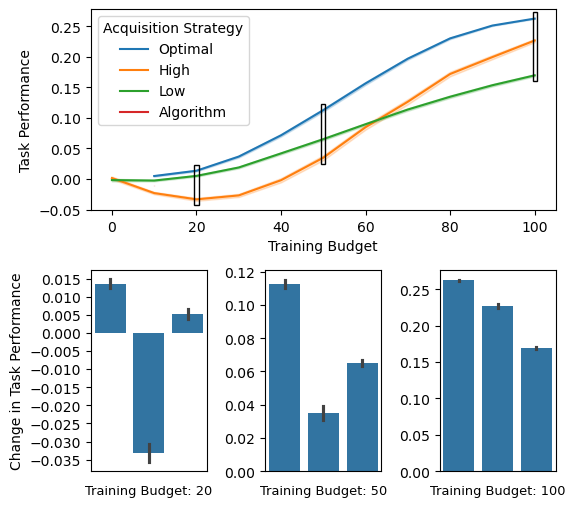

In [68]:
_ = plot(1)

  0%|          | 0/21 [00:00<?, ?it/s]

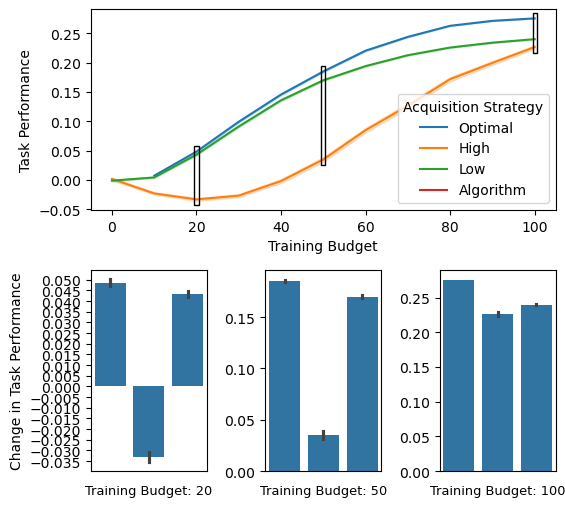

In [69]:
_ = plot(2)

  0%|          | 0/21 [00:00<?, ?it/s]

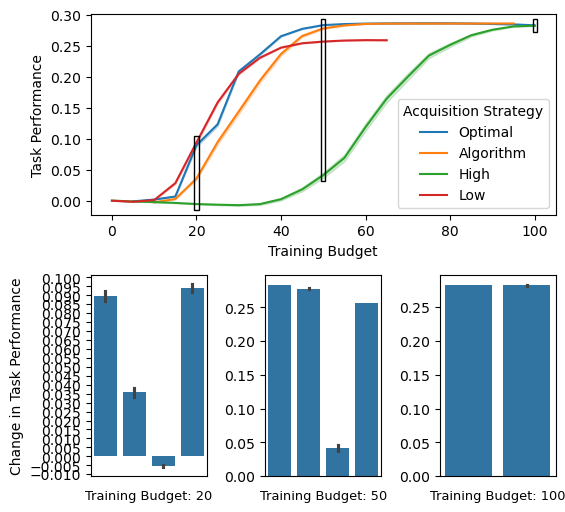

In [42]:
_ = plot(3)

# Algo

In [58]:
from itertools import product

import numpy as np
rng = np.random.default_rng()
from tqdm import tqdm, trange
from tqdm.contrib.concurrent import process_map

import pandas as pd

from helpers import *

def eval_training(modeli, student, teachers, save=False, pct=0):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.get_logger().setLevel('ERROR')
    
    def get_r(model):
        r0, r1 = eval_model(model, 10)
        r = (r0*r1).sum(axis=1).mean()
        return r
        
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(CustomCallback, self).__init__()
        def on_batch_begin(self, batch, logs=None):            
            if save and batch % 1 == 0:
                self.model.rewards[batch] = get_r(self.model)
    
    if student == -1:
        model2 = make_model()
    else:
        model2 = tf.keras.models.load_model(f"models/2x{ms}/starting_{student:.3f}_{modeli%10}.keras")
        
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    model2.rewards = {}
    
    bs = 32
    
    rng = np.random.default_rng(modeli)
    
    X, Y = [], []
    for teacher, n in teachers:
        if isinstance(teacher, tuple):
            X.append([])
            Y.append([])
            for teacher_part in teacher:
                _X, _Y = currs[f"{teacher_part:.3f}"]
                perm = np.random.default_rng(modeli).permutation(len(_X))[:bs * n//len(teacher)]
                # perm = np.random.permutation(len(_X))[:bs * n//len(teacher)]
                X[-1].append(_X[perm])
                Y[-1].append(_Y[perm])
            X[-1] = np.concatenate(X[-1])
            Y[-1] = np.concatenate(Y[-1])
            perm = np.random.permutation(len(X[-1]))
            X[-1] = X[-1][perm]
            Y[-1] = Y[-1][perm]
        else:
            _X, _Y = currs[f"{teacher:.3f}"]
            perm = np.random.permutation(len(_X))[:n*bs]
            X.append(_X[perm])
            Y.append(_Y[perm])

    lx = len(X[0])
    if pct:
        assert (pct*lx) % 1 == 0
        pct2 = int(pct * lx)
        mixX = np.concatenate([_X[lx-pct2:] for _X in X])
        mixY = np.concatenate([_Y[lx-pct2:] for _Y in Y])
        for i, (_X, _Y) in enumerate(zip(X, Y)):
            _X[lx-pct2:] = mixX[i::len(X)]
            _Y[lx-pct2:] = mixY[i::len(Y)]
            perm = np.random.permutation(lx)
            _X[:] = _X[perm]
            _Y[:] = _Y[perm]
    
    X, Y = np.concatenate(X), np.concatenate(Y)        
    model2.fit(X, Y, verbose=False, shuffle=False, batch_size=bs, callbacks=[CustomCallback()]) 
    model2.rewards[len(X)//bs] = get_r(model2)
    
    # with open('/storage1/fs1/chien-ju.ho/Active/gym/tree4.txt', 'a') as f:
    #     for k, v in model2.rewards.items():
    #         print(f"{student};{teachers};{pct};{modeli};{k};{v}", file=f, flush=True)

    return (modeli, student, teachers, model2.rewards)

def exp2(mode, n, nb=100, student=None, algo=None):
    modeli = list(range(n))
    # students = [-1, 100]
    students = [100]
    saves = [False]
    pcts = [0]
    
    if mode == 'one':
        teachers = [[(t, nb*2)] for t in [0.01, 0.032, 0.1, 0.316, 1., 3.162, 10.]]
        saves = [True]
    
    elif mode == 'two-A':
        teachers = (
            [[((0.01,0.032,0.1,0.316), i)] for i in range(4, nb*4+1, 4)]
            + [[((0.316,0.1), i//2), ((0.032,0.01), i//2)] for i in range(4, nb*4+1, 4)]
            + [[(0.316, i//4), (0.1, i//4), (0.032, i//4), (0.01, i//4)] for i in range(4, nb*4+1, 4)]
        )
        
    
    elif mode == 'two-B':
        teachers = [[((0.316,0.1), i//2), ((0.032,0.01), i//2)] for i in range(8, nb*4+1, 8)]
        pcts = [0.25, 0.5, 0.75, 1]
        
    elif mode.startswith('split'):
        k = int(mode[-1])
        teachers = [[(0.1, i*k), (0.01, i)] for i in range(5, nb//2+1, 5)]
        
    elif mode.startswith('optimal'):
        k = int(mode[-1])
        teachers = []
        # for budget in range(10, nb+1, 10):
        for budget in [20, 50, 100]:
            for split in range(0, budget+1, 5):
                teachers.append([(0.1, k*split), (0.01, (budget-split))])
        
    elif mode.startswith('algo'):
        k = int(mode[-1])
        # students = [student]
        n0, n1, diff = algo
        teachers = [
            [(0.1, n0*k), (0.1, diff*k), (0.01, n1)],
            [(0.1, n0*k), (0.01, n1), (0.01, diff)]
        ]
        combo = list(product([n], students, teachers, saves, pcts))
        return list(map(eval_training, *zip(*combo)))
    
    elif mode.startswith('eval'):
        k = int(mode[-1])
        n0, n1 = algo
        teachers = [[(0.1, n0*k), (0.01, n1)]]
        combo = list(product([n], students, teachers, saves, pcts))
        return list(map(eval_training, *zip(*combo)))
        
        
        
    
    combo = list(product(modeli, students, teachers, saves, pcts))
    # print(combo[::10])
    # print(teachers)
    return process_map(eval_training, *zip(*combo), chunksize=1)


In [59]:
from config import *

ntotal = (2**np.array(ns[1:13])).sum()
currs = process_map(make_data, students, [ntotal]*len(students), max_workers=17, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))


  0%|          | 0/9 [00:00<?, ?it/s]

In [60]:
%%time

def exp_algo(k, modeli, budget):
    b = 5
    algo = [b,b]

    path = []
    vals = []

    while sum(algo) < budget:
        res = exp2(f'algo-{k}', modeli, algo=algo+[b])
        res = [list(i[3].values())[0] for i in res]
        algo[np.argmax(res)] += b
        path.append(algo.copy())
        # vals.append(np.max(res))
    return path

def eval_algo(k, modeli, choice):
    return exp2(f'eval-{k}', modeli, algo=choice)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


In [101]:
%%time
def run_exp(k, exps):
    for budget in [100]:
        r = range(exps)
        results = process_map(exp_algo, [k for _ in r], r, [budget for _ in r])

    batches = range(15,101,5)
    for i in range(18):
        perfs2 = process_map(eval_algo, [k for _ in range(exps)], range(exps), [r[i] for r in results])
        with open('/storage1/fs1/chien-ju.ho/Active/gym/tree4.txt', 'a') as f:
            for modeli, perf in enumerate(perfs2):
                v = list(perf[0][3].values())[0]
                # print(f"{100};{f'algo-{k}'};{0};{modeli};{batches[i]};{v}", file=f, flush=True)
                print(f"{100};{f'algo-{k}'};{0};{modeli};{batches[i]};{v}")

CPU times: user 77 µs, sys: 0 ns, total: 77 µs
Wall time: 85.6 µs


In [102]:
%%time
for k in range(1,4):
    run_exp(k, 1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;15;0.7131266088890038


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;20;0.7138190568235405


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;25;0.716055062946718


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;30;0.7206534049419993


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;35;0.7286307758667665


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;40;0.7413229688408621


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;45;0.7626591800246467


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;50;0.7903475990260626


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;55;0.8182644914919808


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;60;0.8470232533710433


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;65;0.9061655160977992


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;70;0.970541640316702


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;75;0.9915563916900915


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;80;0.9972964024159692


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;85;0.9995347700980203


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;90;0.9995882303508837


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;95;0.9995287880421305


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-1;0;0;100;0.9996113645516385


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;15;0.716055062946718


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;20;0.7303476015722593


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;25;0.7590518527248398


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;30;0.8096058599473623


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;35;0.882062520802898


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;40;0.9516298278782983


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;45;0.9865290695661797


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;50;0.9965462356265101


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;55;0.9994367804835044


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;60;0.9996900304538547


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;65;0.9997062504176404


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;70;0.999882380476927


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;75;0.9998302988879859


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;80;0.9996274127399694


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;85;0.9998390887798247


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;90;0.9988435613007061


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;95;0.9994307234531761


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-2;0;0;100;0.999710709206018


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;15;0.7303476015722593


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;20;0.7813733368567214


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;25;0.8820624962244843


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;30;0.9516298182430678


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;35;0.986529061307124


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;40;0.9965462327911571


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;45;0.9994367812243251


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;50;0.9994793974467655


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;55;0.9996032188209656


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;60;0.9997735686098714


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;65;0.9998874656157655


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;70;0.9998908730256899


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;75;0.9991389102935118


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;80;0.9996081985177575


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;85;0.9991634197600392


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;90;0.9993065290593603


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;95;0.9994128775039496


  0%|          | 0/1 [00:00<?, ?it/s]

100;algo-3;0;0;100;0.9995890781545065
CPU times: user 1.59 s, sys: 21.3 s, total: 22.9 s
Wall time: 6min 50s


# 2x10

In [369]:
n = 500

  0%|          | 0/3500 [00:00<?, ?it/s]

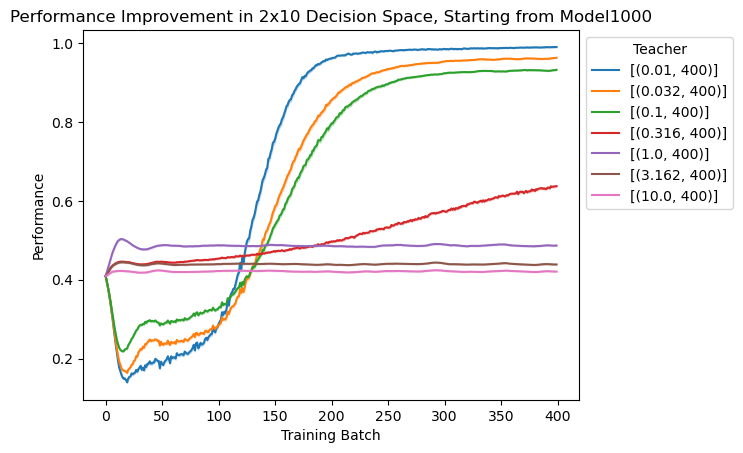

In [370]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='one')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model1000',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

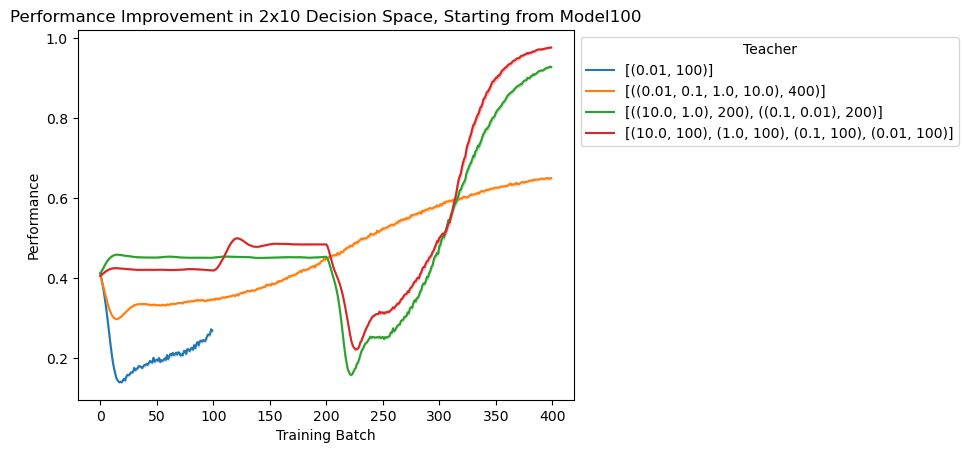

In [371]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='two')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

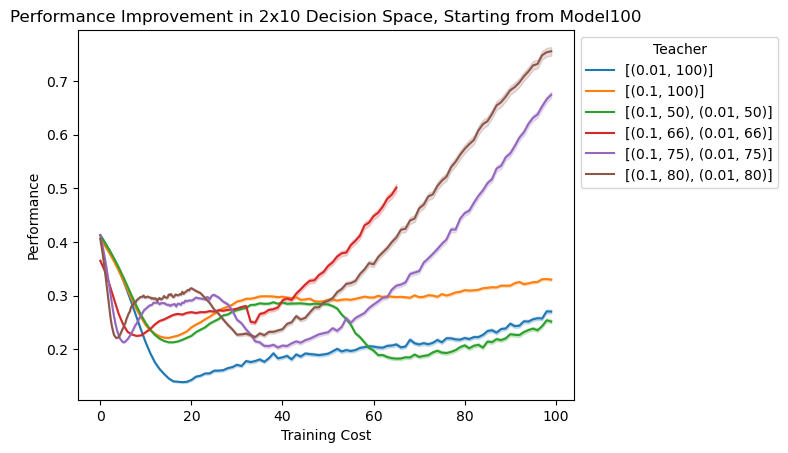

In [372]:
df, df2 = analyze(student=100, n=n, num_batches=100, mode='three')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

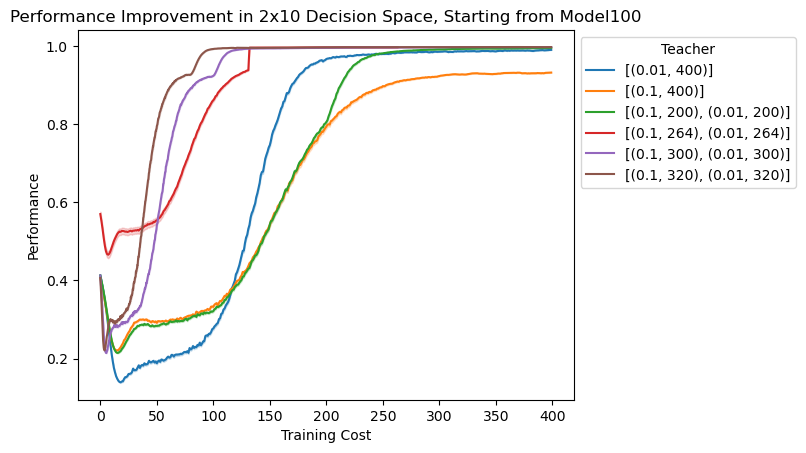

In [373]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='three')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )